<img src="images/dask_horizontal.svg" align="right" width="30%">

# 数组

<img src="images/array.png" width="25%" align="right">
Dask数组使用分块算法提供了一个并行的，大于内存的n维数组。 简而言之：分布式Numpy。

* **并行**：使用计算机上的所有内核
* **大于内存**：通过将数组分成许多小块，以最小化计算的内存占用的顺序操作，可以处理大于可用内存的数据集，并且 有效地从磁盘流式传输数据。
* **分块算法**：通过执行许多较小的计算来执行大型计算

在本笔记本中，我们将通过从头开始实现一些分块的算法来建立一些理解。
然后，我们将使用熟悉的类似NumPy的API，使用Dask Array并行分析大型数据集。

**Related Documentation**

* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)

## 创建数据

In [1]:
%run prep.py -d random

## 设置

In [1]:
from dask.distributed import Client

client = Client(n_workers=12)

## 分块算法

通过将大数据集分解为许多小块，可以执行**分块算法**。

例如，考虑取十亿个数字的总和。 相反，我们可以将数组分成1,000个块，每个块的大小为1,000,000，取每个块的总和，然后取中间总和。

我们通过执行许多较小的结果（每100万个数字一千个和，然后再另一个一千个数字）来达到预期的结果（十亿个数字的一个和）。

在下面的示例中，我们将使用Python和NumPy进行此操作：

In [2]:
# 使用 h5py 加载数据
# 这将创建一个指向数据的指针，但不会实际加载数据
import h5py
import os
f = h5py.File(os.path.join('data', 'random.hdf5'), mode='r')
dset = f['/x']

**使用分块算法计算总和**

在使用dask之前，让我们考虑分块算法的概念。 我们可以通过逐块加载并保持运行总计来计算大量元素的总和。

在这里我们计算磁盘上这个大数组的和

1.计算数组中每个1,000,000大小的块的总和
2.计算1,000个中间总和

请注意，这是notebook内核中的顺序过程，包括加载和求和。

In [ ]:
# 计算大型数组的总和，同时计算一百万个数字
sums = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]  # 取出numpy数组
    sums.append(chunk.sum())

total = sum(sums)
print(total)

### 练习：使用分块算法计算均值

现在，我们已经看到了上面的简单示例，尝试做一个稍微复杂一些的问题，计算数组的均值，假设我们暂时不知道数据中有多少个元素。 您可以通过以下代码更改上面的代码来做到这一点：

1. 计算每个块的总和
2. 计算每个块的长度
3. 计算1,000个中间总和的总和与1,000个中间长度的总和，然后相除。

这种方法对我们的情况来说是过大的了，但是如果我们事先不知道数组或单个块的大小，则可以很好地概括。

In [6]:
# 计算数组的均值

In [ ]:
sums = []
lengths = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]  # 取出numpy数组
    sums.append(chunk.sum())
    lengths.append(len(chunk))

total = sum(sums)
length = sum(lengths)
print(total / length)

dask.array包含这些算法
--------------------------------------------

Dask.array是一个类似于NumPy的库，可以执行这些技巧来处理不适合内存的大型数据集。 它超出了上面讨论的线性问题，扩展到了完整的N维算法和NumPy接口的一个体面的子集。

**创建 `dask.array` 对象**

您可以使用`da.from_array`函数创建一个`dask.array`数组对象。 该功能接受

1.`data`：任何支持NumPy切片的对象，例如`dset`  
2.`chunks`：块大小，告诉我们如何阻塞数组，例如`（1000000，）`

In [3]:
import dask.array as da
x = da.from_array(dset, chunks=(1000000,))
x

,Array,Chunk
Bytes,4.00 GB,4.00 MB
Shape,"(1000000000,)","(1000000,)"
Count,1001 Tasks,1000 Chunks
Type,float32,numpy.ndarray


**像处理numpy数组一样操作`dask.array`对象**

现在我们有了一个`array`，我们可以执行标准的numpy风格的计算，例如算术，数学，切片，归约等。

界面很熟悉，但实际工作有所不同。 `dask_array.sum()`与`numpy_array.sum()`做的不是相同的事情。

**有什么不同?**

`dask_array.sum()`建立一个计算表达式。 它尚未执行计算。 `numpy_array.sum()`立即计算总和。

*为什么有区别？*

Dask数组分为多个块。 每个块必须在该块上显式运行计算。 如果所需的答案来自整个数据集的一小部分，那么对所有数据运行计算将浪费CPU和内存。

In [ ]:
result = x.sum()
result

**计算结果**

Dask.array对象是lazy计算的。 诸如`.sum`之类的操作会建立要执行的分块任务的图。

我们通过调用`.compute()`来获得最终结果。 这触发了实际计算。

In [ ]:
result.compute()

### 练习：计算均值

以及方差，`std`等。这应该是对上面示例的一个很小的更改。

查看使用Jupyter笔记本的Tab键补全可以执行的其他操作。

In [11]:
result = x.mean()
result.compute()

1.0000373

这是否与您之前的结果相符？

性能与并行性
-------------------------------

<img src="images/fail-case.gif" width="40%" align="right">

在我们的第一个示例中，我们使用了“ for”循环来一次遍历一个数组。 对于像sum之类的简单操作，这是最佳选择。 但是，对于复杂的操作，我们可能希望以不同的方式遍历数组。 特别是，我们可能需要以下内容：

1. 并行使用多个内核
2. 在进入下一个块之前，对单个块进行链式操作

Dask.array将您的数组操作转换为相互关联的任务的图，并且它们之间具有数据依赖性。 然后Dask与多个线程并行执行该图。 我们将在下一节中讨论更多有关此的内容。


### 示例

1. 构造一个20000x20000的正态分布随机值数组，将其分解为1000x1000个大小的块
2. 沿一条轴取平均值
3. 每隔100个元素取值

In [4]:
import numpy as np
import dask.array as da

x = da.random.normal(10, 0.1, size=(20000, 20000),   # 4e8个元素的数组 
                              chunks=(1000, 1000))   # 切成 1000x1000 的块
y = x.mean(axis=0)[::100]                            # 进行 NumPy风格的操作

In [13]:
x.nbytes / 1e9  # 大约有多少个G的输入数据

3.2

In [14]:
%%time
y.compute()     # 计算消耗的时间

CPU times: user 816 ms, sys: 51.3 ms, total: 868 ms
Wall time: 2.03 s


array([10.00042893, 10.00119863,  9.99987682,  9.99987076, 10.0011504 ,
        9.99933315,  9.99972801, 10.00023024,  9.99884776, 10.00100312,
       10.00054161, 10.00014204, 10.00040185,  9.99913526, 10.0003232 ,
        9.99914255, 10.00026798,  9.99971378, 10.00048249,  9.99835498,
        9.9999689 ,  9.99914267, 10.00017932, 10.0012862 , 10.00119872,
       10.00010204, 10.0003392 ,  9.99922587, 10.00031549,  9.99959662,
        9.99932901, 10.00001004, 10.00053804, 10.00031897,  9.99952531,
        9.99934926,  9.99910195, 10.00126047,  9.99912053, 10.00036693,
       10.00139961,  9.99986378, 10.00065016,  9.99863512,  9.99936978,
        9.99907648, 10.00062296,  9.99901809, 10.00048306, 10.00046813,
       10.00070167,  9.99970402, 10.00049424, 10.00030298,  9.99910321,
        9.99991187, 10.00142549,  9.99999306, 10.00012462, 10.000128  ,
       10.00113763,  9.99987044, 10.00111934,  9.99956058, 10.00001453,
        9.99947682,  9.99843661,  9.99940118, 10.00073553,  9.99

性能比较
---------------------------

以下实验是在笨重的个人笔记本电脑上进行的。 您的表现可能会有所不同。 如果尝试使用NumPy版本，请确保您拥有4GB以上的主内存。

**NumPy: 19s, 需要以G计的内存**

```python
import numpy as np

%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

CPU times: user 19.6 s, sys: 160 ms, total: 19.8 s
Wall time: 19.7 s
```

**Dask Array: 4s, 需要数M内存**

```python
import dask.array as da

%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 29.4 s, sys: 1.07 s, total: 30.5 s
Wall time: 4.01 s
```

**讨论**

请注意，Dask数组计算运行了4秒，但使用了29.4秒的用户CPU时间。 numpy计算耗时19.7秒，使用了19.6秒的用户CPU时间。

Dask的完成速度更快，但由于块大小而使Dask能够明晰地并行化计算，因此花费了更多的CPU时间。

*提问*

*  如果 dask chunks=(20000,20000)，会发生什么?
    * 计算是否会在4s内完成?
    * 需要消耗多少内存?
*  如果dask chunks=(25,25)，会发生什么?
    * CPU和内存占用会如何变化？

### 练习：气象数据

在`data/weather-big/*`的hdf5文件中有2GB的人造气象数据。 我们将使用`h5py`库与该数据进行交互，并使用`dask.array`对其进行计算。

我们的目标是可视化本月地球表面的平均温度。 这将需要对所有这些数据进行平均。 我们将按照以下步骤进行操作

1. 为磁盘上的每一天数据创建`h5py.Dataset`对象（`dsets`）
2. 用`da.from_array`调用包装它们
3. 通过调用`da.stack`随时间堆叠这些数据集
4. 使用`.mean()`方法计算沿新堆积的时间轴的平均值
5. 使用`matplotlib.pyplot.imshow`可视化结果

In [15]:
%run prep.py -d weather

Created weather dataset in 176.76s


In [9]:
import h5py
from glob import glob
import os

filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]
dsets[0]

<HDF5 dataset "t2m": shape (5760, 11520), type "<f8">

In [17]:
dsets[0][:5, :5]  # 切片为h5py.Dataset对象会得到一个numpy数组

array([[22.53240967, 23.89801025, 25.26361084, 26.62921143, 27.99481201],
       [23.89801025, 25.34637451, 26.79473877, 28.24310303, 29.69146729],
       [25.26361084, 26.79473877, 28.3258667 , 29.85699463, 31.38812256],
       [26.62921143, 28.24310303, 29.85699463, 31.47088623, 33.08477783],
       [27.99481201, 29.69146729, 31.38812256, 33.08477783, 34.78143311]])

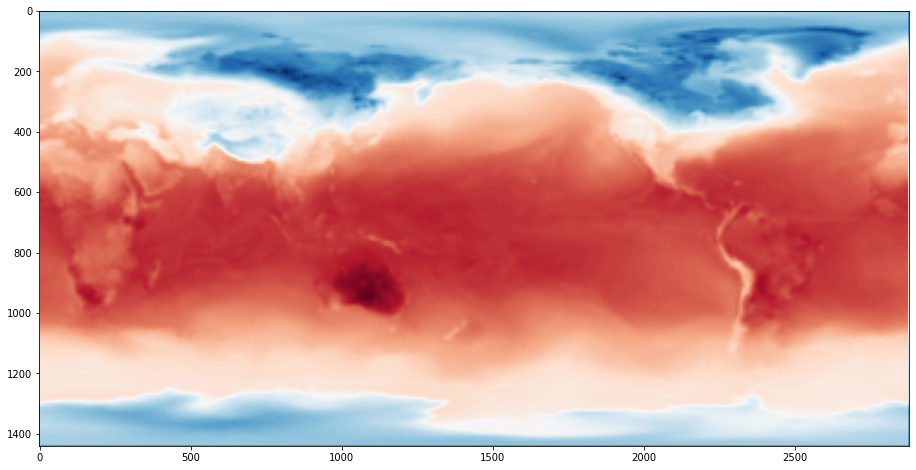

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(dsets[0][::4, ::4], cmap='RdBu_r');

**与`dask.array`集成**

使用chuck大小为`(500,500)`的`da.from_array`函数，从`h5py.Dataset`对象列表中列出`dask.array`对象列表。

In [19]:
arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]
arrays

[dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 50

**将这个数组`dask.array`对象堆叠到一个带有`da.stack`的`dask.array`对象中**

将它们沿着第一条轴堆叠，以使结果数组的形状为`(31,5760,11520)`。

In [20]:
x = da.stack(arrays, axis=0)
x

,Array,Chunk
Bytes,16.46 GB,2.00 MB
Shape,"(31, 5760, 11520)","(1, 500, 500)"
Count,17887 Tasks,8928 Chunks
Type,float64,numpy.ndarray


**沿时间`(第0)`轴绘制此数组的平均值**

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

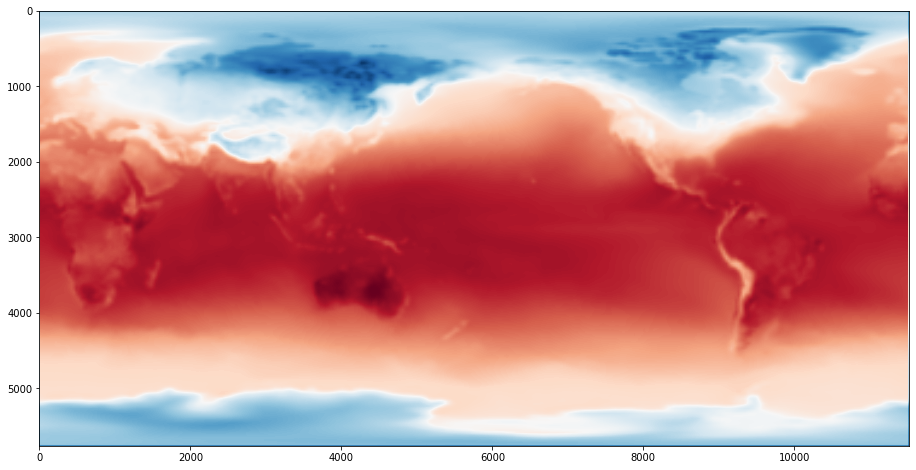

In [24]:
result = x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r');

**绘制第一天与平均值的差**

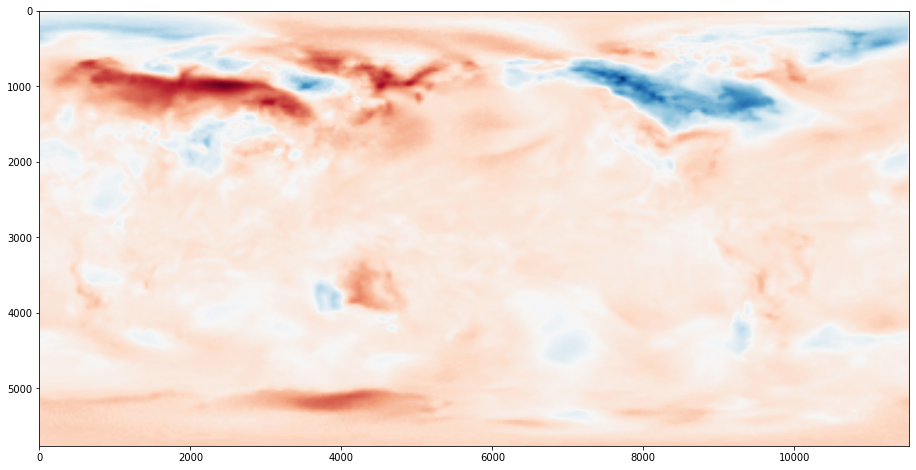

In [25]:
result = x[0] - x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r');

### 练习：子样本和存储

在上面的练习中，我们的计算结果很小，因此我们可以安全地调用`compute`。 有时我们的结果仍然太大而无法容纳到内存中，因此我们想将其保存到磁盘中。 在这些情况下，您可以使用以下两个功能之一

1.  `da.store`: 将`dask.array`存储到任何支持numpy setitem语法的对象中, 例如.

        f = h5py.File('myfile.hdf5')
        output = f.create_dataset(shape=..., dtype=...)
        
        da.store(my_dask_array, output)
        
2.  `da.to_hdf5`: 一种特制的函数，用于创建dask.array对象并将其存储到HDF5文件中。

        da.to_hdf5('data/myfile.hdf5', '/output', my_dask_array)
        
本练习中的任务是**使用numpy步骤切片在纬度和经度方向上对整个数据集进行二次抽样，然后再使用上面列出的功能之一将此结果存储到磁盘**。

提醒一下，Python切片需要三个要素

    start:stop:step

    >>> L = [1, 2, 3, 4, 5, 6, 7]
    >>> L[::3]
    [1, 4, 7]

In [5]:
import h5py
from glob import glob
import os
import dask.array as da

filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]

arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]

x = da.stack(arrays, axis=0)

result = x[:, ::8, ::8]



In [6]:
result

,Array,Chunk
Bytes,257.13 MB,31.75 kB
Shape,"(31, 720, 1440)","(1, 63, 63)"
Count,26815 Tasks,8928 Chunks
Type,float64,numpy.ndarray


In [ ]:
result.compute()

In [10]:
#方法1
if os.path.exists(os.path.join('data', 'myfile1.hdf5')):
    os.remove(os.path.join('data', 'myfile1.hdf5'))

In [11]:
f = h5py.File(os.path.join('data', 'myfile1.hdf5'),'w')

In [ ]:
output = f.create_dataset(name="myfile1",shape= (31, 720, 1440), dtype=np.float64,data=result)

In [ ]:
da.store(result, output)

In [ ]:
#方法2
da.to_hdf5(os.path.join('data', 'myfile2.hdf5'), result,  overwrite=True)

## 示例：兰纳-琼斯势

[兰纳-琼斯势](https://zh.wikipedia.org/wiki/兰纳-琼斯势)被用于物理，化学和工程领域的粒子模拟。 它是高度可并行化的。
首先，我们将对7,000个粒子运行和配置Numpy版本。

In [2]:
import numpy as np

# 随机收集颗粒
def make_cluster(natoms, radius=40, seed=1981):
    np.random.seed(seed)
    cluster = np.random.normal(0, radius, (natoms,3))-0.5
    return cluster

def lj(r2):
    sr6 = (1./r2)**3
    pot = 4.*(sr6*sr6 - sr6)
    return pot

# 建立距离矩阵
def distances(cluster):
    diff = cluster[:, np.newaxis, :] - cluster[np.newaxis, :, :]
    mat = (diff*diff).sum(-1)
    return mat

# 在删除接近零的距离后，将在上三角形上评估lj函数
def potential(cluster):
    d2 = distances(cluster)
    dtri = np.triu(d2)
    energy = lj(dtri[dtri > 1e-6]).sum()
    return energy

In [3]:
cluster = make_cluster(int(7e3), radius=500)

In [4]:
%time potential(cluster)

CPU times: user 1.59 s, sys: 1.58 s, total: 3.17 s
Wall time: 3.03 s


-0.21282893668845293

请注意，最耗时的功能是`distances`:

In [5]:
# 这将在另一个浏览器标签中打开
# %load_ext snakeviz
# %snakeviz potential(cluster)

# 在此选项卡中给出文本结果的替代简单版本
%prun -s tottime potential(cluster)

         35 function calls (34 primitive calls) in 1.984 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.697    0.348    0.697    0.348 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.613    0.613    1.298    1.298 <ipython-input-2-2011832079fa>:15(distances)
        1    0.493    0.493    0.493    0.493 <ipython-input-2-2011832079fa>:9(lj)
      2/1    0.089    0.044    0.100    0.100 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.080    0.080    1.983    1.983 <ipython-input-2-2011832079fa>:21(potential)
        1    0.011    0.011    0.011    0.011 {method 'outer' of 'numpy.ufunc' objects}
        1    0.002    0.002    1.984    1.984 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 {built-in method numpy.arange}
        1    0.000    0.000    1.984    1.984 {built-in method builtins.exec}
        1    0.000    0.000    0.011    0.011 twod

### Dask 版本

这是 Dask 的版本，只有`potential`函数需要重写,以最好地利用 Dask。

注意，`da.nansum` 已经在完整的 $NxN$ 距离矩阵上使用，以提高并行效率。

In [10]:
import dask.array as da

# 计算整个距离矩阵的势，忽略除以零
def potential_dask(cluster):
    d2 = distances(cluster)
    energy = da.nansum(lj(d2))/2.
    return energy

让我们将 NumPy 数组转换为 Dask 数组。由于整个 NumPy 数组可以安装在内存中，所以按照 CPU 核心数量来分块数组更加有效。

In [11]:
from os import cpu_count

dcluster = da.from_array(cluster, chunks=cluster.shape[0]//cpu_count())

这个步骤应该可以很好地扩展核心的数量。warning是在报告`divide by zero`，这就是为什么我们在`potential_dask`中使用`da.nansum`。

In [12]:
e = potential_dask(dcluster)
%time e.compute()

/data_1/anaconda3/envs/pl/lib/python3.7/site-packages/dask/array/core.py:3956: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,


CPU times: user 896 ms, sys: 0 ns, total: 896 ms
Wall time: 1.76 s


-0.21282893668845304

局限性
-----------

Dask 数组并没有实现整个 numpy 接口。对此抱有期望的用户可能会感到失望。

值得注意的是，dask数组有以下缺点:

1.  Dask 没有实现所有的``np.linalg``。这已经通过许多优秀的 BLAS/LAPACK 实现完成，并且是许多正在进行的学术研究项目的重点。
2.  Dask Array 不支持结果形状取决于数组值的某些操作。对于那些它支持的(例如，用另一个布尔掩码屏蔽一个 Dask Array) ，块大小将是未知的，这可能会导致需要知道块大小的其他操作的问题。
3.  Dask Array 不会尝试``sort``之类的操作，众所周知，这类操作很难并行执行，而且对于非常大的数据而言，这些操作的价值有所降低(实际上很少需要完整的排序)。
    我们经常会使用类似``topk``这样的并行友好的替代词。
4.  Dask 的开发是由即时需求驱动的，所以很多较少使用的函数，比如``np.sometrue``,纯粹由于我们的懒惰，并没有完全实现。这些都会为社区做出很好的贡献。
    
* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)

In [13]:
client.shutdown()